# Statistical Hacking

This file serves as a reference for:
* ECDF graphs
* Bootstrapping
* Permutation Tests
* Hypothesis Testing

### Getting Started

In [2]:
# Loading libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [3]:
# Loading in data
bd_1975 = pd.read_csv("finch_1975.csv")['Beak depth, mm'].values
bd_2012 = pd.read_csv("finch_2012.csv")['bdepth'].values

### Defining functions

In [4]:
#ECDF plotting function
def ecdf(array):
    n = len(array)
    x = np.sort(array)
    y = np.arange(1, n+1) / n
    return x, y

In [5]:
# Boostrap replicates function
def draw_bs_reps(data, func, size):
    bs_replicates = np.empty(size)
    for num in range(size):
        bs_replicates[num] = func(np.random.choice(data, size=len(data)))
    return bs_replicates

In [ ]:
# Permutation sample function. Testing to see if data came from same distribution
# For example ab testing.
def permutation_sample(data1, data2):
    data = np.concatenate((data1, data2)) # Assuming data came from same distribution
    permuted_data = np.random.permutation(data) # Shuffling data. Pulling new data
    # under the assumption of the null hypothesis
    perm_sample1 = permuted_data[:len(data1)]
    perm_sample2 = permuted_data[len(data1):]
    return perm_sample1, perm_sample2


### Some EDA

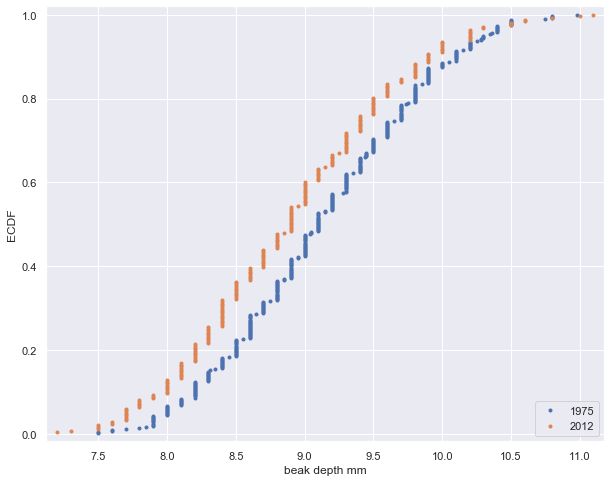

In [6]:
sns.set() # Setting seaborn theme

# ECDF Plots
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

_ = plt.figure(figsize=(10,8))

_ = plt.plot(x_1975, y_1975, marker=".", linestyle='none')
_ = plt.plot(x_2012, y_2012, marker=".", linestyle='none')

plt.margins(.02)

_ = plt.xlabel("beak depth mm")
_ = plt.ylabel("ECDF")
_ = plt.legend(("1975", "2012"), loc='lower right')

plt.show()

### Parameter Estimates of beak depths

In [8]:
# Computing empirical difference of means
mean_diff = np.mean(bd_1975) - np.mean(bd_2012)

# Getting bootstrap replicates
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, 10000)

# Getting difference of means
bs_diff_replicates = bs_replicates_1975 - bs_replicates_2012

# Getting 95% confidence interval
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])
print(f"difference of means: {mean_diff} mm")
print(f"95% confidence interval: {conf_int} mm")

difference of means: 0.22313275434243174 mm
95% confidence interval: [0.10604397 0.33880909] mm


### Hypothesis Test: Are beaks deeper
The hypothesis is that the means are equal. Not that they come from the same
distribution. Same distribution means permutation test.

In [10]:
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the means to both equal combined mean. Null Hypothesis is that the means
# are the same
shifted_1975 = bd_1975 - np.mean(bd_1975) + combined_mean
shifted_2012 = bd_2012 - np.mean(bd_2012) + combined_mean

# Get boostrap replicates of these shifted arrays
bs_shifted_1975 = draw_bs_reps(shifted_1975, np.mean, 10000)
bs_shifted_2012 = draw_bs_reps(shifted_2012, np.mean, 10000)

# Get the difference of the means for each replicate
bs_diff_shifted = bs_replicates_1975 - bs_shifted_2012

# Compute the pvalue. Under the null hypothesis that the beak depths have the same
# means. What is the probability that we get our observed/empirical difference of
# means
p = np.sum(bs_diff_shifted >= mean_diff) / len(bs_diff_shifted)

# Print results
print(f"P-value: {p}")

P-value: 0.0093


### Final Notes

Hypothesis Testing:

* Clearly state the null hypothesis
* Compute empirical test statistic
* Draw thousands of permutations samples assuming the null hypothesis to be true
    * Compute test statistic for those samples
* Compute p-value
    * np.sum(perm_replicates >= actual_test_statistic) / len(perm_replicates)